In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, brier_score_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Data exploration

In [3]:
data = pd.read_csv('cybersecurity_training.csv', sep='|')

In [4]:
data.head()

,alert_ids,client_code,notified,categoryname,ip,ipcategory_name,ipcategory_scope,parent_category,grandparent_category,overallseverity,...,thrcnt_week,thrcnt_day,p6,p9,p5m,p5w,p5d,p8m,p8w,p8d
0,Nhq,DPM,0,Attack,YT.LB.32.21,INTERNET,Internet,7,A,3,...,4160,675,1,0,2,1,1,1,1,1
1,XZt,FIN,0,Exploit,192.SL.UK.94,PRIV-192,Private network,1,A,5,...,9,2,4,12,3,2,2,2,1,1
2,bBz,CHP,0,Attack,YT.LB.38.21,INTERNET,Internet,7,A,4,...,3788,628,1,0,2,2,1,2,2,1
3,ZNr,HPS,0,Attack,JX.NY.13.20,INTERNET,Internet,7,A,4,...,565,96,0,0,2,2,2,2,2,2
4,poV,OSC,0,Attack,YT.LB.32.21,INTERNET,Internet,7,A,4,...,2790,632,1,0,1,1,1,1,1,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39427 entries, 0 to 39426
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   alert_ids                 39427 non-null  object 
 1   client_code               39427 non-null  object 
 2   notified                  39427 non-null  int64  
 3   categoryname              39427 non-null  object 
 4   ip                        39427 non-null  object 
 5   ipcategory_name           39427 non-null  object 
 6   ipcategory_scope          39427 non-null  object 
 7   parent_category           39427 non-null  int64  
 8   grandparent_category      39427 non-null  object 
 9   overallseverity           39427 non-null  int64  
 10  timestamp_dist            39427 non-null  int64  
 11  start_hour                39427 non-null  int64  
 12  start_minute              39427 non-null  int64  
 13  start_second              39427 non-null  int64  
 14  weekda

In [6]:
datay = data['notified']
dataX = data.drop(columns=['notified'])
raw_train, raw_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.30, random_state=42)
df = raw_train.copy()

In [7]:
y_train.value_counts()

0    26028
1     1570
Name: notified, dtype: int64

z data.info wiemy, że w danych nie ma nulli oprócz w kolumnach ni i score

In [8]:
df['n1'].value_counts()

0.0    4786
1.0     203
Name: n1, dtype: int64

In [9]:
df[df['n1'].isna()]['n1']

7740    NaN
18253   NaN
32139   NaN
5005    NaN
36529   NaN
         ..
6265    NaN
11284   NaN
38158   NaN
860     NaN
15795   NaN
Name: n1, Length: 22609, dtype: float64

Sprawdźmy mediany dla poszczególnych kolumn, którymi wypełnimy braki danych

In [10]:
for i in range(1, 12):
    if i < 11:
        name = 'n' + str(i)
    else:
        name = 'score'
    print(f'median: {df[name].median()}')
    print(df[name].value_counts())
    print()

median: 0.0
0.0    4786
1.0     203
Name: n1, dtype: int64

median: 0.0
0.0    4976
1.0      13
Name: n2, dtype: int64

median: 0.0
0.0    3322
1.0    1667
Name: n3, dtype: int64

median: 0.0
0.0    3851
1.0    1138
Name: n4, dtype: int64

median: 0.0
0.0    3291
1.0    1698
Name: n5, dtype: int64

median: 0.0
0.0    2665
1.0    2324
Name: n6, dtype: int64

median: 0.0
0.0    4989
Name: n7, dtype: int64

median: 0.0
0.0    4989
Name: n8, dtype: int64

median: 0.0
0.0    4905
1.0      84
Name: n9, dtype: int64

median: 0.0
0.0    4989
Name: n10, dtype: int64

median: 2.0
1.0    1707
3.0    1216
0.0     744
4.0     666
2.0     464
5.0     174
6.0      17
7.0       1
Name: score, dtype: int64



Widzimy, że wszędzie oprócz score jest to 0. 

In [11]:
df['alert_ids'].value_counts()

kdx    1
sOs    1
QOA    1
bFV    1
JEp    1
      ..
Gwl    1
GcV    1
dGe    1
FqH    1
tgd    1
Name: alert_ids, Length: 27598, dtype: int64

alert_ids to tylko id alertu - zbędna kolumna do analizy danych. sprawdźmy jeszcze co z client_code

In [12]:
df['client_code'].value_counts()

REQ    616
OAO    409
VME    351
EOL    317
ZZE    298
      ... 
WDO      2
BCX      2
TTW      2
EBH      1
JGW      1
Name: client_code, Length: 274, dtype: int64

In [13]:
df['ip'].value_counts()

YT.LB.32.21      2691
YT.LB.34.21      1884
YT.LB.36.21      1781
YT.LB.38.21      1702
MC.ER.197.27     1122
                 ... 
172.ZC.RX.11        1
IA.RZ.66.25         1
10.GV.PO.195        1
YA.YT.194.111       1
AH.XW.187.112       1
Name: ip, Length: 9938, dtype: int64

Kiepska sprawa, aż 276 różnych kodów klientów. Trudno powiedzieć co z tym zrobić - być może także wywalić, no bo co ma klient wspólnego z typem i niebezpieczeństwem alertu. Tak samo pozbęde się ip (oczywiście możnaby się pobawić, rozdzielić ip na oktety i zrobić z tego kolumny, ale to może innym razem;) - zresztą i tak mamy już kolumny z kategoriami czy domenami ip)

In [14]:
df_cat = df.select_dtypes(include=['object']).drop(columns=['alert_ids', 'client_code', 'ip'])
df_cat

,categoryname,ipcategory_name,ipcategory_scope,grandparent_category,weekday,dstipcategory_dominate,srcipcategory_dominate
7740,Attack,INTERNET,Internet,A,Tue,INTERNET,INTERNET
18253,Exploit,PRIV-172,Private network,A,Sun,INTERNET,INTERNET
32139,Suspicious Reputation,PRIV-10,Private network,A,Thu,INTERNET,INTERNET
5005,Exploit,INTERNET,Internet,A,Thu,INTERNET,INTERNET
21165,Attack,INTERNET,Internet,A,Sat,INTERNET,PRIV-172
...,...,...,...,...,...,...,...
6265,Exploit,INTERNET,Internet,A,Fri,INTERNET,PRIV-172
11284,Attack,INTERNET,Internet,A,Tue,INTERNET,PRIV-10
38158,Reconnaissance,INTERNET,Internet,A,Thu,INTERNET,INTERNET
860,Exploit,INTERNET,Internet,A,Wed,INTERNET,PRIV-10


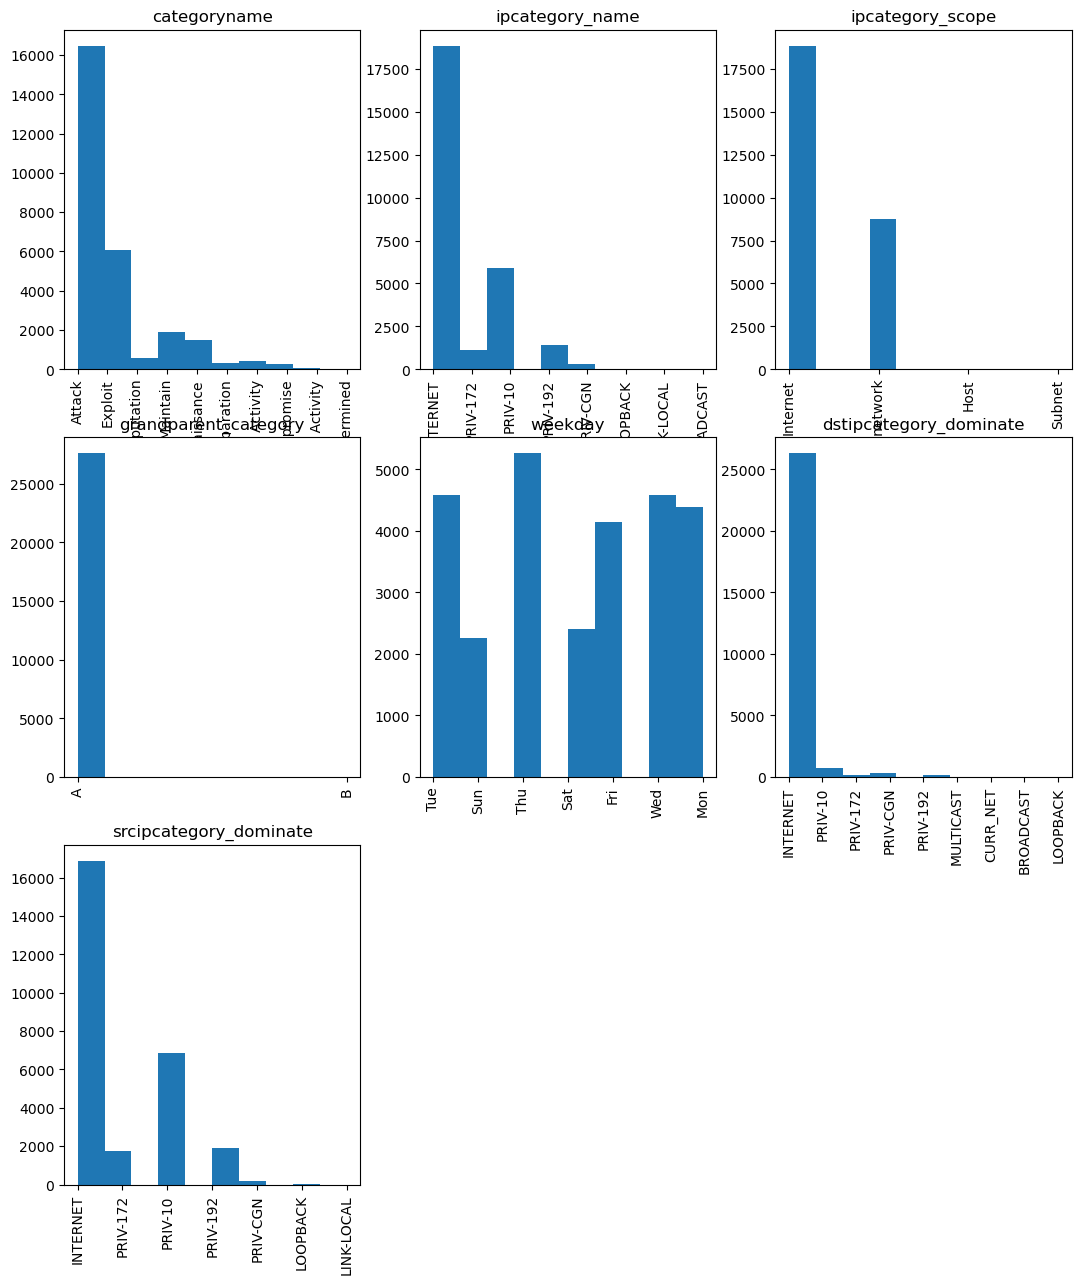

In [15]:
fig = plt.figure(figsize=(13, 15))
for i, col in enumerate(df_cat.columns):
    ax = fig.add_subplot(3, 3, i+1)
    ax.hist(df_cat[col])
    ax.set_title(col)
    ax.tick_params(axis='x', labelrotation=90)

w pozostałych kolumnach jest rozsądna liczba kategorii, więc możemy spróbować zastosować one hot encoding. z kolei z grandparent_category możemy zrobić kolumnę typu bool

In [16]:
df_cat2 = df.select_dtypes(include=['object']).drop(columns=['alert_ids', 'client_code', 'ip', 'grandparent_category'])
df = pd.get_dummies(df, columns=df_cat2.columns, dtype=int)

In [17]:
df['grandparent_category'] = df['grandparent_category'].replace({'A': 0, 'B': 1})

In [18]:
df.drop(columns=['alert_ids', 'client_code', 'ip'], inplace=True)

In [19]:
df

,parent_category,grandparent_category,overallseverity,timestamp_dist,start_hour,start_minute,start_second,correlatedcount,n1,n2,...,dstipcategory_dominate_PRIV-172,dstipcategory_dominate_PRIV-192,dstipcategory_dominate_PRIV-CGN,srcipcategory_dominate_INTERNET,srcipcategory_dominate_LINK-LOCAL,srcipcategory_dominate_LOOPBACK,srcipcategory_dominate_PRIV-10,srcipcategory_dominate_PRIV-172,srcipcategory_dominate_PRIV-192,srcipcategory_dominate_PRIV-CGN
7740,7,0,4,0,21,12,47,1,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
18253,1,0,3,107021,18,14,33,7,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
32139,1,0,4,0,3,38,1,1,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
5005,7,0,5,0,23,43,54,1,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
21165,7,0,5,53716,14,20,49,55,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,7,0,2,0,12,46,48,1,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
11284,7,0,3,4116,18,39,58,2,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
38158,7,0,5,0,5,40,15,1,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
860,7,0,5,0,19,32,29,3,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


zrobiło się troche dużo kolumn. sprawdźmy które zmienne są skorelowane:

<AxesSubplot:>

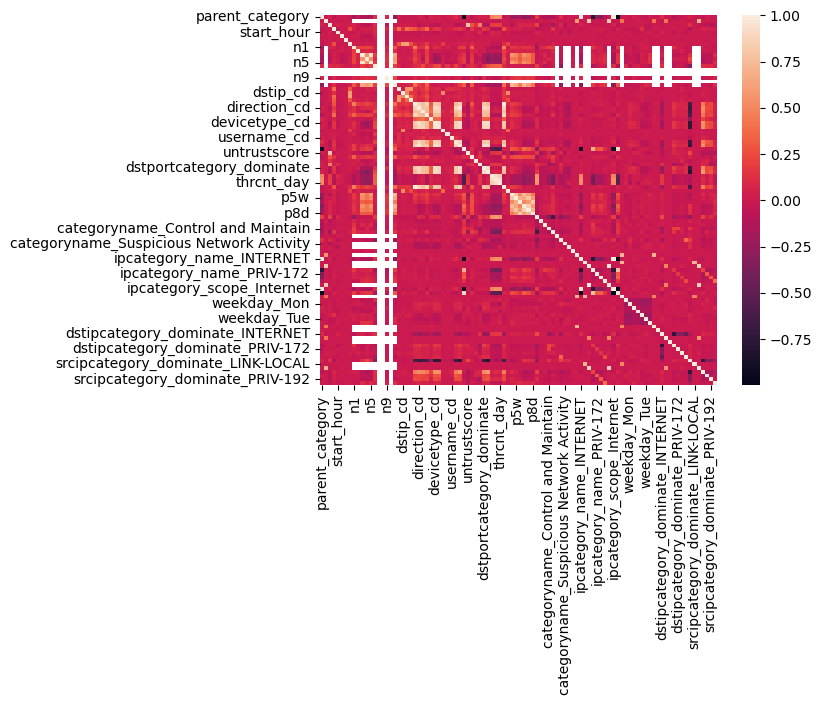

In [20]:
sns.heatmap(df.corr())

In [21]:
matrix_cols = []
for col1 in df.columns:
    correlated = False
    for col2 in df.columns:
        if col1 != col2:
            corr = df[[col1, col2]].corr().iloc[0,1]
            if np.abs(corr) > 0.8:
                matrix_cols.append(col1)
                correlated = True
                break

In [22]:
subset_df = df[matrix_cols]

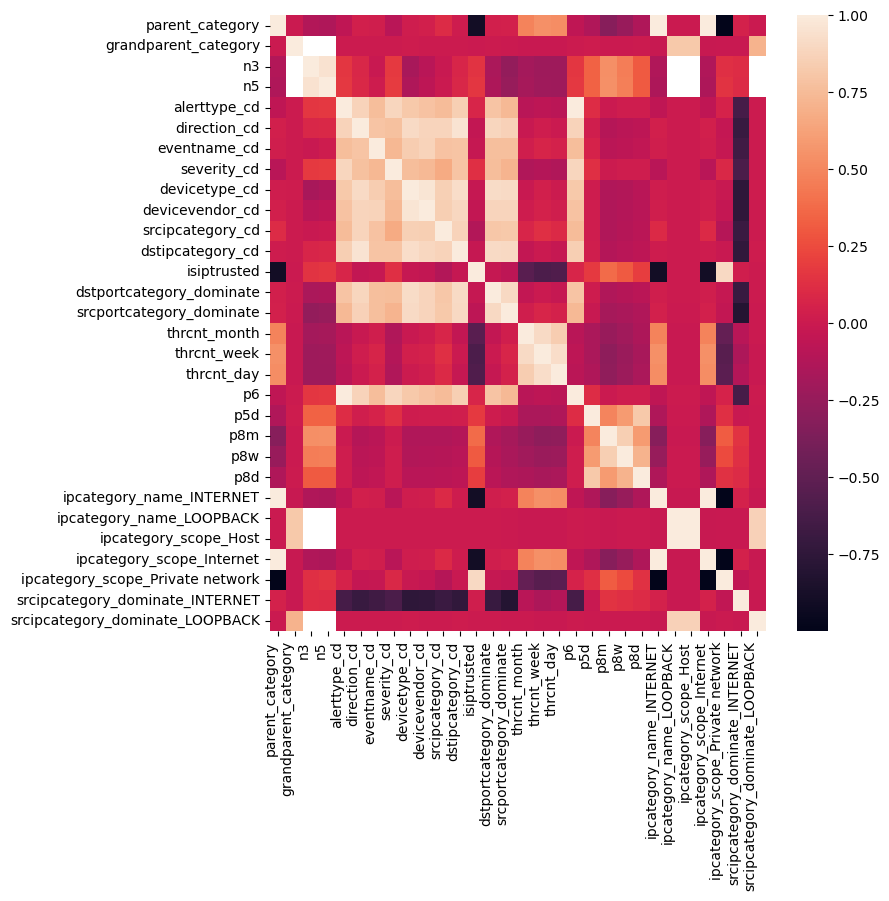

In [23]:
corr_matrix = subset_df.corr()

# Create the heatmap with all column names as tick labels
plt.figure(figsize=(8, 8))  # Adjust the figure size if needed
ax = sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

# Adjust tick label rotation and alignment
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

In [24]:
df.drop(columns=['n3', 'n4', 'srcipcategory_dominate_INTERNET',  'p6'], inplace=True)

# Preprocessing

In [25]:
def handle_nans(df):
    for i in range(1, 12):
        if i < 11:
            col = 'n' + str(i)
        else:
            col = 'score'
        try:
            median = df[col].median()
        except:
            median = 0
        df[col].fillna(median, inplace=True)
    return df

In [26]:
def drop_columns(df, corr=True):
    cols_to_drop = ['alert_ids', 'client_code', 'ip']
    if corr:
        cols_to_drop.extend(['n3', 'n4', 'p6'])
    df = df.drop(columns=cols_to_drop)
    return df

In [27]:
def replace_outliers(data, k=1.5):
    # zrobiłem też funkcję do usuwania outlierów, ale najprawdopodobniej jej nie użyję, gdyż w tego typu danych outliery 
    # mogą świadczyć o niebezpieczeństwie
    data = data.copy()
    for col in data.columns:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound

    return data

In [28]:
def encode_columns(df):
    df_cat = df.select_dtypes(include=['object']).drop(columns=['grandparent_category'])
    df = pd.get_dummies(df, columns=df_cat.columns, dtype=int)
    df['grandparent_category'] = df['grandparent_category'].replace({'A': 0, 'B': 1})
    df.drop('srcipcategory_dominate_INTERNET', axis=1, inplace=True)
    return df

In [29]:
def standarize(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)
    return df

In [30]:
na_transformer = FunctionTransformer(handle_nans)
drop_transformer = FunctionTransformer(drop_columns)
column_transformer = FunctionTransformer(encode_columns)
stand_transformer = FunctionTransformer(standarize)

transform_pipe = Pipeline([
    ("na", na_transformer),
    ('drop', drop_transformer),
    ('columns', column_transformer),
#     ('stand', stand_transformer),
])

In [31]:
def metrics(name, y_true,y_pred, y_probabilities = np.empty(shape=(0,))):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, pos_label=0)
    F1_score = f1_score(y_true, y_pred, pos_label=0)
    if len(y_probabilities.tolist()) == 0:
        Log_loss=None
        auc_score = roc_auc_score(y_true, y_pred)
    else:
        Log_loss = log_loss(y_true, y_probabilities)
        auc_score = roc_auc_score(y_true, y_probabilities[:, 1])
    my_dict = {'Classifier': name, 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1 score': [F1_score], 'auc score': [auc_score], 'log loss': [Log_loss] }
    df = pd.DataFrame.from_dict(my_dict) 
    return df
def metrics_dataframe(model_dict, y_true):
    accuracy_df = pd.DataFrame()
    for name, val in model_dict.items():
        accuracy_df = accuracy_df.append(pd.DataFrame(metrics(name ,y_true, val[0], val[1])).set_index('Classifier'))
    accuracy_df = accuracy_df.round(decimals=4)
    return accuracy_df

In [32]:
X_test = raw_test.copy()
X_train = raw_train.copy()

In [33]:
test_transformed = transform_pipe.transform(X_test)
train_transformed = transform_pipe.transform(X_train)

In [80]:
len(test_transformed) == len(train_transformed)

False

przez one hot encoding liczba kolumn różni się w Xtrain i Xtest

In [81]:
def fix_columns(train_transformed, test_transformed):
    missing_columns = [col for col in train_transformed.columns if col not in test_transformed.columns]
    additional_columns = [col for col in test_transformed.columns if col not in train_transformed.columns]
    
    for col in missing_columns:
        test_transformed[col] = 0
    for col in additional_columns:
        train_transformed[col] = 0
        
    test_transformed = test_transformed.reindex(columns=train_transformed.columns)
    return train_transformed, test_transformed

In [82]:
train_transformed, test_transformed = fix_columns(train_transformed, test_transformed)

# Model

In [36]:
# Linear Regression
reg = LogisticRegression(random_state=42)
reg.fit(train_transformed, y_train)
lr_predicted = reg.predict(test_transformed)
lr_predicted_probability = reg.predict_proba(test_transformed)

In [37]:
# XG Boost
xgb = XGBClassifier()
xgb.fit(train_transformed, y_train)
xg_predicted = xgb.predict(test_transformed)
xg_predicted_probability = xgb.predict_proba(test_transformed)

In [38]:
# Random Forest
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(train_transformed, y_train)
# scores = cross_val_score(clf, test_transformed, y_test, cv=5)
rf_predicted = clf.predict(test_transformed)
rf_predicted_probability = clf.predict_proba(test_transformed)

In [39]:
model_dict = {'Logistic regression': [lr_predicted, lr_predicted_probability]}
model_dict['XG boost'] = [xg_predicted, xg_predicted_probability]
model_dict['Random Forest'] = [rf_predicted, rf_predicted_probability]
metrics_dataframe(model_dict, y_test)

,accuracy,precision,recall,f1 score,auc score,log loss
Classifier,,,,,,
Logistic regression,0.9401,0.4583,0.9988,0.9691,0.6896,0.2474
XG boost,0.9432,0.5739,0.9912,0.9704,0.8912,0.1588
Random Forest,0.9442,0.6474,0.9951,0.9710,0.8298,0.4888


widzimy, że wszystkie klasyfikatory mają bardzo wysoki recall. To co wyróżnia RF jest o wiele wyższa prezycja. Jednakże, najważniejszą dla nas metryką jest roc_auc_score a ten najwyższy ma XG Boost. 

In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
params = { 
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    "max_depth": range(3,21,3),
    "gamma": [i/10.0 for i in range(0,5)],
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

xg_model = XGBClassifier()
random = RandomizedSearchCV(estimator=xg_model, param_distributions=params, n_iter = 15, cv = kfold, n_jobs=-1, scoring='roc_auc')
random_result = random.fit(train_transformed, y_train)

print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.901718 using {'reg_lambda': 10, 'reg_alpha': 1e-05, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7}


In [41]:
xgbest = XGBClassifier(reg_lambda= 10, reg_alpha=1e-05, max_depth=15, learning_rate=0.1, gamma=0.0, colsample_bytree=0.7)
xgbest.fit(train_transformed, y_train)
xgbest_predicted = xgbest.predict(test_transformed)
xgbest_predicted_probability = xgbest.predict_proba(test_transformed)

In [42]:
metrics('final XG Boost', y_test, xgbest_predicted, xgbest_predicted_probability)

,Classifier,accuracy,precision,recall,f1 score,auc score,log loss
0,final XG Boost,0.945135,0.683871,0.995595,0.971531,0.902686,0.151557


Uzyskaliśmy o wiele lepsze metryki

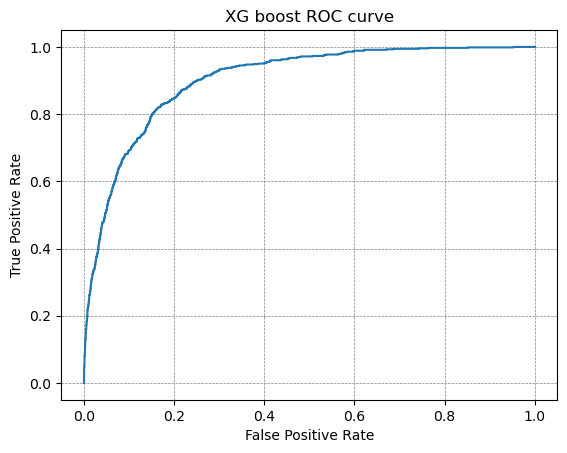

In [75]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  xgbest_predicted_probability[::,1])

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('XG boost ROC curve')
plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.show()

# Test data

In [62]:
raw_test_data = pd.read_csv('cybersecurity_test.csv', sep='|')

In [63]:
train_transformed, test_data = fix_columns(transform_pipe.transform(X_train), transform_pipe.transform(raw_test_data))

In [65]:
test_data

,parent_category,grandparent_category,overallseverity,timestamp_dist,start_hour,start_minute,start_second,correlatedcount,n1,n2,...,srcipcategory_dominate_LINK-LOCAL,srcipcategory_dominate_LOOPBACK,srcipcategory_dominate_PRIV-10,srcipcategory_dominate_PRIV-172,srcipcategory_dominate_PRIV-192,srcipcategory_dominate_PRIV-CGN,ipcategory_name_BENCH,ipcategory_name_MULTICAST,dstipcategory_dominate_LINK-LOCAL,srcipcategory_dominate_BENCH
0,7,0,3,0,11,44,26,1,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,7,0,5,0,22,39,30,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,3,0,7,57,5,1,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,3,0,0,21,33,1,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,7,0,3,258273,18,39,29,14,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7,0,2,43201,19,12,7,3,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
19996,7,0,3,0,13,1,26,1,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
19997,1,0,5,1,18,44,8,2,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
19998,7,0,3,748,8,47,38,1,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
xgbest = XGBClassifier(reg_lambda= 10, reg_alpha=1e-05, max_depth=15, learning_rate=0.1, gamma=0.0, colsample_bytree=0.7)
xgbest.fit(train_transformed, y_train)
xgtest_predicted = xgbest.predict(test_data)
xgtest_predicted_probability = xgbest.predict_proba(test_data)

In [74]:
np.savetxt('score2.txt', xgtest_predicted_probability[:,1], fmt='%.4f')